<a href="https://colab.research.google.com/github/victor-armegioiu/Learning-Bayesian-Priors/blob/main/Prior_as_Particles_(Standard_VI_for_posterior_training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Better priors represented as particles

---

Seed papers: FUNCTIONAL VARIATIONAL BAYESIAN NEURAL NETWORKS (https://arxiv.org/pdf/1903.05779.pdf)

Understanding Variational Inference in Function-Space (https://arxiv.org/pdf/2011.09421.pdf)



## Setup 

Necessary imports, setting up the Colab environment.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# gpflow doesn't come preloaded with colab.
!pip3 install gpflow

In [3]:
import numpy as np
import time

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib
import matplotlib.pyplot as plt

from gdrive.MyDrive.prior_learning.spectral_stein_grad.estimator import SpectralScoreEstimator
from gdrive.MyDrive.prior_learning import data_utils
from gdrive.MyDrive.prior_learning import prior_utils
from gdrive.MyDrive.prior_learning import sliced_score_estimation

tf.compat.v1.enable_eager_execution()


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
tf.executing_eagerly()

True

In [5]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Building the dataset

We are going to draw `task_count` tasks, where the index sets for each tasks are drawn as $x \sim  \mathcal{U}(-5, 5)$, and the regression targets are generated as  $f(x) = β \cdot x + a \cdot \sin(1.5 \cdot (x − b)) + c$, where $\beta, a, b, c$ are per-task hyperparameters.





In [6]:
# Draws the hyperparameters needed for each task.
task_count = 10
tasks_data = data_utils.GetSinusoidParams(task_count)

In [7]:
config = {
          'input_shape': 1,             # Shape of input data.
          'size': 5,                    # Number of samples per task.  
          'generation_method': 'sine',  # Generating process of the labels.
          'tasks_data': tasks_data,     # Hyperparams for the sinusoids.
}

Use last `test_tasks_cnt` for testing, and leave the rest for training. 

In [8]:
X, y = data_utils.GetDataset(config)
X = X[:, None]
test_tasks_cnt = 1

first_test_idx = len(X) - test_tasks_cnt * config['size']
X_train, y_train = X[:first_test_idx], y[:first_test_idx]
X_test, y_test = X[first_test_idx:], y[first_test_idx:]

In [9]:
X_train.shape, X_test.shape

((45, 1), (5, 1))

In [10]:
scaler = StandardScaler().fit(X_train)

In [11]:
# Use the same scaler in order to ensure that we don't inject knowledge
# about the test distribution in our training biases.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

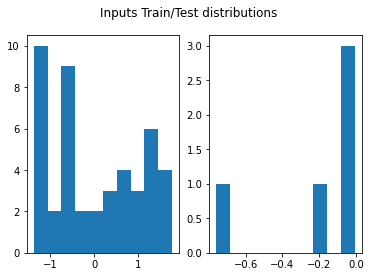

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Inputs Train/Test distributions')
ax1.hist(X_train, bins=10)
ax2.hist(X_test, bins=10)
plt.show()

In [13]:
# Scale both dataset by `y_train_max`. Same reasoning
# as in using the same scaler on inputs. This is done to avoid
# exploding gradients.
y_train_max = y_train.max()
y_train /= y_train_max
y_test /= y_train_max

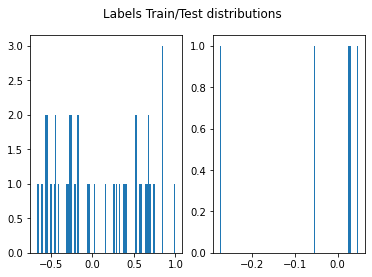

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Labels Train/Test distributions')
ax1.hist(y_train, bins=100)
ax2.hist(y_test, bins=100)
plt.show()

## GP Prior Setup

Train a $\mathcal{GP}$ on the training data, so that we may later use the tuned kernel for estimating the covariance of a Normal distribution over function values (this shall be used as the prior in the `f-bnn` formulation below).

In [15]:
# Pre-train GP prior.
gp_prior, _ = prior_utils.TrainGPPrior(X_train, y_train)

## Sliced Score Estimator Setup (https://arxiv.org/pdf/1905.07088.pdf)

Here we train a network $h(\cdot, \hat{\theta})$ which minimizes the objective $\mathbb{E}_{x \sim \mu} \Vert h(x, \hat{\theta}) - \nabla_x \log p(x) \Vert_{2}$ in an unsupervised way, where $\mu$ is some unknown data generating process and $p := \sum_i \delta_{x_i}$ is an empirical measure represented as a set of particles.

In [16]:
input_shape = (1,)
score_net = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape, name='input'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(input_shape[0]),
])

config_slice_train = {'data': y_train[:, None],
          'score_net': score_net,
          'epochs': 100, 
          'lambda_reg': 0.15
}

In [17]:
score_net, best_loss = (
    sliced_score_estimation.GetSlicedScoreEstimator(config_slice_train,
                                                    verbose=True))

Epoch [0], loss: [3.894559]
Epoch [10], loss: [3.276264]
Epoch [20], loss: [0.376394]
Epoch [30], loss: [-0.546520]
Epoch [40], loss: [-1.567371]
Epoch [50], loss: [-3.748332]
Epoch [60], loss: [-3.213116]
Epoch [70], loss: [-3.008458]
Epoch [80], loss: [-6.224043]
Epoch [90], loss: [-6.151384]


## Model setup

This section covers the actual training of our particle based models, minimizing the `f-bnn` loss (likelihood term + $KL$ term), where we represent the prior as a set of particles. The prior particles themselves will be the actual **training targets**, since we regard them to be representative of the true generating process.

In [18]:
def ApproximateEntropyGrads(estimator, samples):
  dlog_q = estimator.compute_gradients(samples)
  surrogate = tf.reduce_mean(
      tf.reduce_sum(
          tf.stop_gradient(-dlog_q) * tf.cast(samples, tf.float64), -1))
  return surrogate

In [19]:
# Estimator to be used for computing score gradients of implicit distributions
# represtend as sets of particles.
estimator = SpectralScoreEstimator(n_eigen_threshold=0.99, eta=0.0)

In [20]:
# TODO: Allow for customizable models.
def _GetModel():
  kl_divergence_function = (lambda q, p, _:
                            tfp.distributions.kl_divergence(q, p) /
                            tf.cast(len(X_train), dtype=tf.float32))

  # Setup a feed forward BNN with 1 hidden layer.
  model = tf.keras.Sequential([
      tf.keras.Input(shape=X_train[0].shape,name='input'),
      tfp.layers.DenseFlipout(10, kernel_divergence_fn=kl_divergence_function,
                              activation=tf.nn.relu, name="dense_tfp_1"),
      tfp.layers.DenseFlipout(1,
                              kernel_divergence_fn=kl_divergence_function,
                              name="out_tfp_pred"),
  ])

  return model

Reframing variational inference in the function space, we arrive at the following objective formulation [Sun et al., 2019]

\begin{equation}
 \log p(\mathcal{D} \vert f) - \lambda KL(q \Vert p) \hspace{0.5cm}(1)
\end{equation}

where $q, p$ represent the posterior, and the prior over function values.

Using the reparametrization trick, function values $f(x) \sim q(\cdot)$ are drawn from a parameterized neural net $g_\phi(x ; \xi)$. Here $\phi$ denotes the set of optimizable parameters, while $\xi$ is a random perturbation under which the change of variable is performed. Hence, drawing samples $f(x) \sim q$ is done by forwarding $x$ through $g_\phi(\cdot ; \xi)$.

In order to obtain a feasible optimization procedure from $(1)$, the $KL$ divergence gradient is then expanded as 

\begin{equation}
 \nabla_\phi KL(q \Vert p)  = \mathbb{E}_{\xi}[\nabla_\phi \textbf{f} (\nabla_\textbf{f} \log q(\textbf{f}) - \nabla_\textbf{f}\log p(\textbf{f})  )] \hspace{0.5cm}(2)
\end{equation}

Note that the $KL$ term is made tractable by using SSGE [Shi et al., 2018] to extract gradients for the score functions, since both $q(\cdot), p(\cdot)$ are both implicit distributions represented as particles.

In [21]:
# Draw samples from the variational posterior.
def SamplePosterior(variational_posterior, n_particles, x, training=False):
  return tf.stack([variational_posterior(x, training=training)  
                    for _ in range(n_particles)])

In [ ]:
def Train(model=_GetModel(),
          epochs=200,
          n_particles=10,
          task_size=5,
          prior_particles=np.copy(y_train),
          use_functional_kl=True,
          lambda_kl=1.0,
          method='sliced_score_estimation',
          verbose=True):

  criterion = tf.keras.losses.MeanSquaredError()
  optimizer = tf.keras.optimizers.Adam(0.001)
  test_losses = [] # Record losses we see during testing.

  # The real targets are the true prior.
  if len(prior_particles.shape) == 2:
    prior_particles = np.squeeze(prior_particles, -1)

  # Configs used as arguments for the `ComputeCrossEntropy` function, which
  # will be used for computing the log_prior gradients
  # (or approximate gradients). The method field indicates which log-prior
  # gradient scheme we will use. Only 'gp' comes with an analytical form.
  # for the gradients, trading off expresiveness.
  configs = {
    'gp': {'method': 'gp',  'kernel_function': gp_prior.kernel},

    'ssge': {'method': 'ssge', 'estimator': estimator,
            'n_particles': n_particles, 'prior_particles': prior_particles},

    'sliced_score_estimation': {'method': 'sliced', 
                                'score_estimator': score_net},
  }

  if use_functional_kl:
    print('Using %s for computing log-prior gradients. \n' % method)

  for epoch in range(epochs):
    task_idx = np.random.choice(np.arange(task_count - test_tasks_cnt))
    start, end = task_idx * task_size, (task_idx + 1) * task_size 
    
    with tf.GradientTape() as g:
      predictions = SamplePosterior(model, n_particles, X_train[start:end],
                                    True)
      log_likelihood = -criterion(tf.reduce_mean(predictions, axis=0),
                                  y_train[start:end])
      log_likelihood_copy = log_likelihood.numpy()
      
      if use_functional_kl:
          # Use SSGE to approximate the log gradients of the functional
          # posterior given the 'drawn' samples from the neural net.
          # See Equation (2).
          posterior_samples = (
              predictions + np.random.normal(0, 1, size=predictions.shape))
          entropy_sur = ApproximateEntropyGrads(estimator, posterior_samples)
        
          if 'gp' in method:
            configs[method]['x'] = X_train[start:end]
            configs[method]['y'] = tf.squeeze(posterior_samples, axis=2)
          elif 'ssge' in method:
            configs[method]['y'] = posterior_samples
          elif 'score' in method:
            configs[method]['y'] = tf.reshape(posterior_samples,
                [n_particles *  len(y_train[start:end]), -1])
            
          cross_entropy_sur = prior_utils.ComputeCrossEntropy(configs[method])
          
          # Add these up to produce the KL term to be optimized.
          functional_kl = (tf.cast(entropy_sur, tf.float32) -
                            tf.cast(cross_entropy_sur, tf.float32))
          log_likelihood += (lambda_kl * tf.cast(functional_kl, tf.float64) /
                            len(X_train[start:end]))
    
      grads = g.gradient(-log_likelihood, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

    if verbose and epoch % 50 == 0:
      test_predictions = SamplePosterior(model, n_particles, X_test, False)
      test_log_likelihood = -criterion(tf.reduce_mean(predictions, axis=0), 
                                      y_test)
      print('Epoch [%d] test log-likelihood: [%f]' %
            (epoch, test_log_likelihood,))
      test_losses.append(test_log_likelihood.numpy())
      
  return (model, test_losses)

## Results

We run the models in two regimes:



1.   Just use $MLE$ for training, no functional $KL$.
2.   Use the full `f-bnn` objective (Eq. (1)), where we perform the log-prior gradient estimation with each of : `Sliced Score Estimation`, `GP Prior`, `Spectral Stein Gradient Estimator`.

We run the training loop `tries_per_method` times for each of the 4 above combinations.



In [23]:
from collections import defaultdict

statistics = defaultdict(list)
tries_per_method = 3

for method in [(False, 'mle'), (True, 'sliced_score_estimation'),
               (True, 'ssge'), (True, 'gp')]:
  for i in range(tries_per_method):
    print(method, i)
    model, test_losses = Train(use_functional_kl=method[0],
                              method=method[1], verbose=True)
    statistics[method].append(test_losses[-1])

(False, 'mle') 0
Epoch [0] test log-likelihood: [-0.035488]
Epoch [50] test log-likelihood: [-0.043097]
Epoch [100] test log-likelihood: [-0.034992]
Epoch [150] test log-likelihood: [-0.028489]
(False, 'mle') 1
Epoch [0] test log-likelihood: [-0.039183]
Epoch [50] test log-likelihood: [-0.033278]
Epoch [100] test log-likelihood: [-0.040513]
Epoch [150] test log-likelihood: [-0.025199]
(False, 'mle') 2
Epoch [0] test log-likelihood: [-0.037234]
Epoch [50] test log-likelihood: [-0.029327]
Epoch [100] test log-likelihood: [-0.042094]
Epoch [150] test log-likelihood: [-0.042524]
(True, 'sliced_score_estimation') 0
Using sliced_score_estimation for computing log-prior gradients. 

Instructions for updating:
Use `tf.cast` instead.
Epoch [0] test log-likelihood: [-0.026206]
Epoch [50] test log-likelihood: [-0.022022]
Epoch [100] test log-likelihood: [-0.031119]
Epoch [150] test log-likelihood: [-0.021398]
(True, 'sliced_score_estimation') 1
Using sliced_score_estimation for computing log-prio

In [25]:
# Show confidence intervals for all results corresponding to each method.
import scipy.stats as st

for method, results in statistics.items():
  print(method[1], ': ', st.t.interval(0.95, len(results) - 1,
                                 loc=np.mean(results), scale=st.sem(results)))

mle :  (-0.054926711804943046, -0.009214515748345104)
sliced_score_estimation :  (-0.02682774522168263, -0.015596957174312831)
ssge :  (-0.04224282658340274, -0.018889731106740845)
gp :  (-0.029247469877773893, -0.021340258741801607)
